#Training The Model With Random Forest And SVM

1. Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


⚙️ 2. Install Dependencies

In [2]:
!pip install opencv-python scikit-image scikit-learn xgboost joblib


📦 3. Import Libraries

In [15]:
import cv2
import numpy as np
import os
from glob import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


🧼 4. Residual Noise Extraction

In [3]:
def extract_residual_noise(image_path, size=(512, 512)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, size)
    blur = cv2.GaussianBlur(img, (3, 3), 0)
    residual = img.astype(np.float32) - blur.astype(np.float32)
    return residual


🧬 5. Build Fingerprints from Flatfield Images

In [4]:
def build_fingerprint(scanner_folder):
    residuals = []
    for img_path in glob(os.path.join(scanner_folder, '*.tif')):
        residuals.append(extract_residual_noise(img_path))
    return np.mean(residuals, axis=0)


📊 6. Feature Extraction

In [5]:
def correlate_with_fingerprint(residual, fingerprint):
    return np.corrcoef(residual.flatten(), fingerprint.flatten())[0, 1]

def fft_features(residual):
    fft = np.fft.fft2(residual)
    fft_shift = np.fft.fftshift(fft)
    magnitude = np.abs(fft_shift)
    return [np.mean(magnitude), np.std(magnitude)]

def create_feature_vector(doc_path, fingerprints):
    residual = extract_residual_noise(doc_path)
    features = [correlate_with_fingerprint(residual, fp) for fp in fingerprints]
    features += fft_features(residual)
    return features


📁 7. Load Dataset & Prepare Training Data for Official documents

In [12]:

flatfield_path = '/content/drive/MyDrive/AI-TraceFinder/Flatfield'
official_path = '/content/drive/MyDrive/AI-TraceFinder/Official'
wikipedia_path = '/content/drive/MyDrive/AI-TraceFinder/Wikipedia'

fingerprints = []
scanner_labels = []

# Build fingerprints from Flatfield images
for scanner_dir in os.listdir(flatfield_path):
    fp = build_fingerprint(os.path.join(flatfield_path, scanner_dir))
    fingerprints.append(fp)
    scanner_labels.append(scanner_dir)

# Prepare training data from Official and Wikipedia documents
X, y = [], []
for dataset_path in [official_path, wikipedia_path]:
    for scanner_dir in os.listdir(dataset_path):
        label = scanner_dir
        scanner_path = os.path.join(dataset_path, scanner_dir)

        for dpi in ['150', '300']:
            dpi_path = os.path.join(scanner_path, dpi)
            if os.path.exists(dpi_path): # Check if dpi_path exists
                tif_files = glob(os.path.join(dpi_path, '*.tif'))

                for img_path in tif_files:
                    try:
                        features = create_feature_vector(img_path, fingerprints)
                        if features:
                            X.append(features)
                            y.append(label)
                    except Exception as e:
                        print(f"Error processing {img_path}: {e}")

🧠 8. Train & Evaluate Model With RandomForestClassifier

              precision    recall  f1-score   support

  Canon120-1       0.66      0.67      0.67        95
  Canon120-2       0.65      0.71      0.68        84
    Canon220       0.92      0.86      0.88        76
 Canon9000-1       0.61      0.48      0.54        75
 Canon9000-2       0.63      0.68      0.65        65
 EpsonV370-1       0.74      0.85      0.79        88
 EpsonV370-2       0.86      0.78      0.82        95
  EpsonV39-1       0.61      0.71      0.66        72
  EpsonV39-2       0.63      0.56      0.59        87
   EpsonV550       0.98      0.96      0.97        97
          HP       0.93      0.94      0.93        80

    accuracy                           0.75       914
   macro avg       0.75      0.75      0.74       914
weighted avg       0.75      0.75      0.75       914



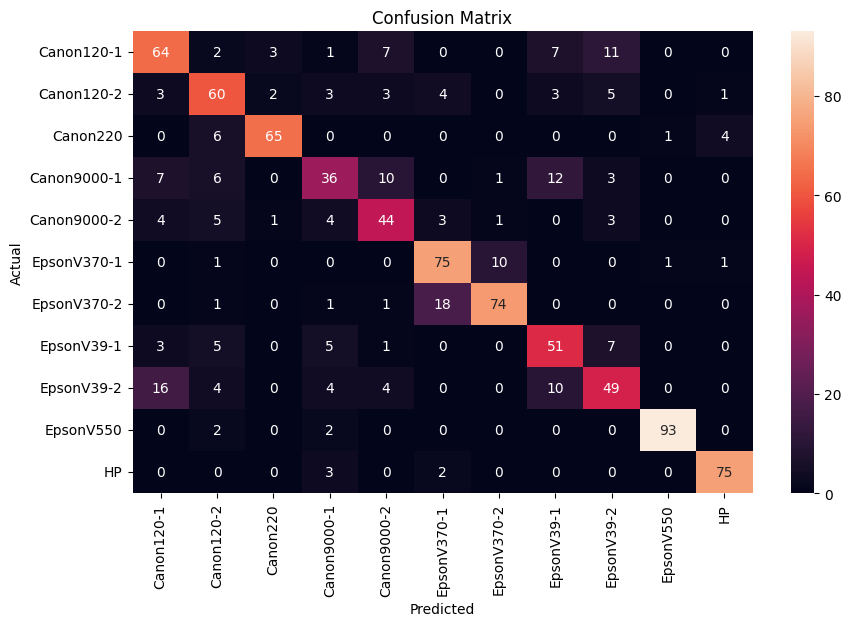

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


🔍 ✅ Train and Evaluate Model with SVM

              precision    recall  f1-score   support

  Canon120-1       0.41      0.39      0.40        95
  Canon120-2       0.30      0.24      0.27        84
    Canon220       0.65      0.59      0.62        76
 Canon9000-1       0.20      0.17      0.18        75
 Canon9000-2       0.17      0.25      0.20        65
 EpsonV370-1       0.76      0.69      0.73        88
 EpsonV370-2       0.88      0.73      0.80        95
  EpsonV39-1       0.44      0.68      0.54        72
  EpsonV39-2       0.43      0.61      0.51        87
   EpsonV550       0.84      0.92      0.88        97
          HP       0.79      0.29      0.42        80

    accuracy                           0.52       914
   macro avg       0.53      0.50      0.50       914
weighted avg       0.55      0.52      0.52       914



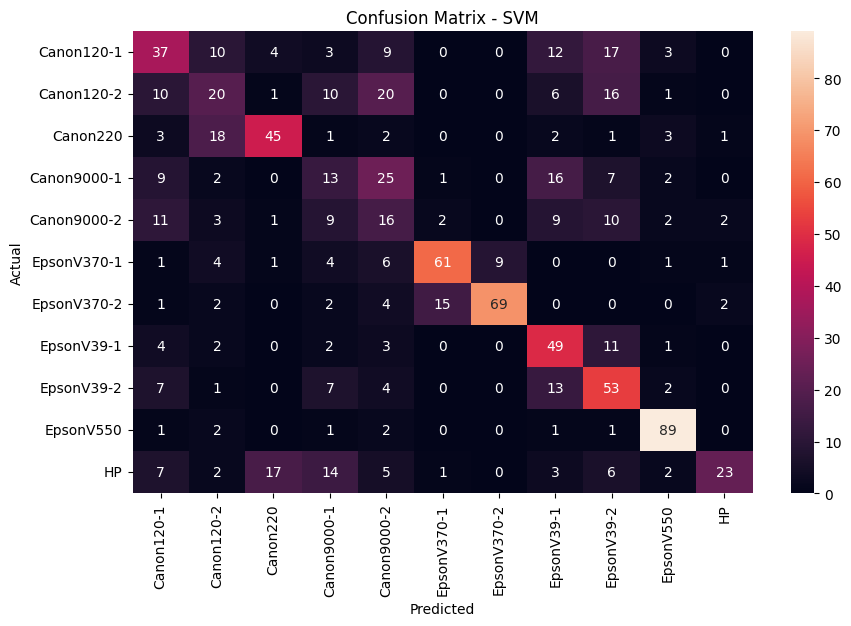


Test Accuracy (SVM): 0.5197


In [31]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Accuracy on test set
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy (SVM): {test_accuracy:.4f}")

Saving RandomForestModel

In [39]:
import joblib

# Save model
rf_path = '/content/drive/MyDrive/Models/rf_model.joblib'
joblib.dump(model, rf_path)

print(f"Random Forest model saved to: {rf_path}")


Random Forest model saved to: /content/drive/MyDrive/Models/rf_model.joblib


Saving SVM Model

In [40]:

svm_path = '/content/drive/MyDrive/Models/svm_model.joblib'
joblib.dump(svm_model, svm_path)

print(f"SVM model saved to: {svm_path}")

SVM model saved to: /content/drive/MyDrive/Models/svm_model.joblib


#Training The Model With CNN

🔗 1. Mount Google Drive

In [41]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. Install Dependencies

In [42]:
!pip install opencv-python scikit-learn matplotlib


📦 3. Import Libraries

In [43]:
import cv2
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


4. Residual Noise Extraction

In [44]:
def extract_residual_noise(image_path, size=(128, 128)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = cv2.resize(img, size)
    blur = cv2.GaussianBlur(img, (3, 3), 0)
    residual = img.astype(np.float32) - blur.astype(np.float32)
    residual = residual / 255.0  # Normalize
    return residual


5. Load and Label Dataset (Official + Wikipedia)

In [45]:
def load_dataset(root_path):
    images = []
    labels = []
    for scanner_dir in os.listdir(root_path):
        label = scanner_dir
        for dpi in ['150', '300']:
            dpi_path = os.path.join(root_path, scanner_dir, dpi)
            for img_path in glob(os.path.join(dpi_path, '*.tif')):
                residual = extract_residual_noise(img_path)
                if residual is not None:
                    images.append(residual)
                    labels.append(label)
    return np.array(images), np.array(labels)

official_path = '/content/drive/MyDrive/AI-TraceFinder/Official'
wikipedia_path = '/content/drive/MyDrive/AI-TraceFinder/Wikipedia'

X_official, y_official = load_dataset(official_path)
X_wiki, y_wiki = load_dataset(wikipedia_path)

# Combine datasets
X = np.concatenate([X_official, X_wiki], axis=0)
y = np.concatenate([y_official, y_wiki], axis=0)


In [47]:
print(X.shape)
print(y.shape)

(4568, 128, 128)
(4568,)


6. Encode Labels & Prepare Data

In [48]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Reshape for CNN input
X = X.reshape(-1, 128, 128, 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)



In [49]:
print(X_train.shape)
print(y_train.shape)

(3654, 128, 128, 1)
(3654, 11)


7. Build CNN Model

In [51]:
# with strategy.scope():
import tensorflow as tf
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(y_categorical.shape[1], activation='softmax')
    ])
model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [52]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,393,163 (28.20 MB)

 Trainable params: 7,393,163 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

None


8. Train the Model

In [53]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=30, batch_size=64,
                    validation_split=0.2, callbacks=[early_stop])


Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.0877 - loss: 2.4220 - val_accuracy: 0.1040 - val_loss: 2.3974
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.1232 - loss: 2.3928 - val_accuracy: 0.1382 - val_loss: 2.3779
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.1764 - loss: 2.3241 - val_accuracy: 0.1833 - val_loss: 2.1772
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.3050 - loss: 1.9502 - val_accuracy: 0.2886 - val_loss: 1.8528
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4813 - loss: 1.4556 - val_accuracy: 0.3912 - val_loss: 1.5356
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6088 - loss: 1.0552 - val_accuracy: 0.4118 - val_loss: 1.3596
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7153 - loss: 0.7549 - val_accuracy: 0.4870 - val_loss: 1.2762
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7995 - loss: 0.5501 - val_accuracy: 0.4979 

📊 9. Evaluate Accuracy

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.5247 - loss: 1.2251

✅ Test Accuracy: 0.5153


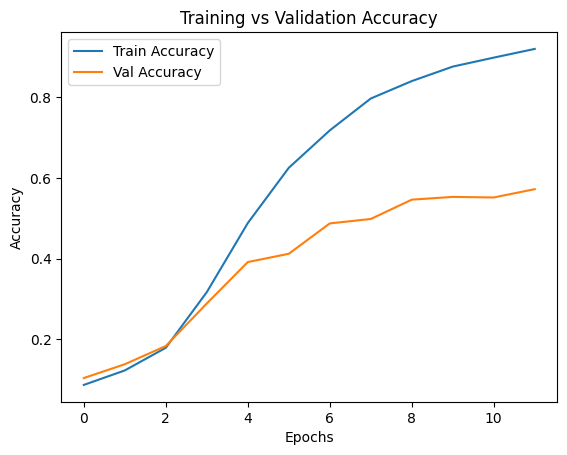

In [54]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


Saving CNN model

In [57]:
import joblib

joblib.dump(model, '/content/drive/MyDrive/Models/CNN_1_model.pkl')
print("Model saved")


Model saved


In [87]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3654, 128, 128, 1)
(3654, 11)
(914, 128, 128, 1)
(914, 11)
